<h1>Проект "Дашборд конверсий"</h1>
<h2>1. Подготовка к работе с данными</h2>

In [2]:
import pandas as pd

In [3]:
url_v = 'https://drive.google.com/file/d/1QosQQ4RRNR9rkL4t7sB707h2Uy0XfYJe/view'
url_v = 'https://drive.google.com/uc?id=' + url_v.split('/')[-2]
visits = pd.read_csv(url_v)
visits.date = pd.to_datetime(visits.date)
#visits.head()

In [4]:
url_r = 'https://drive.google.com/file/d/1AeQz0kaSgz0lxYSDtuNm36muhy5fRCzZ/view'
url_r = 'https://drive.google.com/uc?id=' + url_r.split('/')[-2]
regs = pd.read_csv(url_r)
regs.date = pd.to_datetime(regs.date)
#regs.head()

In [5]:
visits = visits[(visits['date'] >= '2023-03-01') & (visits['date'] < '2023-09-01')]
regs = regs[(regs['date'] >= '2023-03-01') & (regs['date'] < '2023-09-01')]

In [6]:
visits.describe()

,date
count,1000
mean,2023-03-02 18:25:04.564000256
min,2023-03-01 00:05:35
25%,2023-03-01 12:02:27
50%,2023-03-01 23:28:04.500000
75%,2023-03-03 21:42:13.249999872
max,2023-03-07 23:05:08


In [7]:
regs.describe()

,date,user_id
count,1000,1.000000e+03
mean,2023-03-03 10:59:03.900000,4.488623e+06
min,2023-03-01 00:12:22,2.236800e+04
25%,2023-03-02 14:08:57.500000,2.235489e+06
50%,2023-03-03 10:33:06,4.473044e+06
75%,2023-03-04 07:32:06.500000,6.779707e+06
max,2023-03-05 22:04:01,8.881772e+06
std,NaN,2.620568e+06


<h2>2. Запросы к API</h2>

In [8]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd

In [9]:
load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [10]:
#r_v = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
r_v = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end' : DATE_END})
r_r = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end' : DATE_END})

In [11]:
visits = pd.DataFrame(r_v.json())
#visits.head()

In [12]:
regs = pd.DataFrame(r_r.json())
#registrations.head()

<h2>3. Расчет метрик</h2>

<h3>3.1. Удаление ботов из списка посетителей</h3>

In [13]:
def get_humans(x):
    if 'bot' in x.lower():
        return 'bot'
    else:
        return 'human'

visits['human_or_bot'] = visits['user_agent'].apply(lambda x: get_humans(x))
visits = visits[visits['human_or_bot'] == 'human'].drop(['human_or_bot'], axis=1)
#visits.head()

<h3>3.2. Выбор последних визитов в случае нескольких записей с одинаковым 'visit_id':</h3>

In [14]:
visits['datetime'] = pd.to_datetime(visits['datetime'])#.dt.date
visits['visit_no'] = visits.groupby('visit_id').ngroup()
visits = visits.sort_values(by=['visit_id', 'datetime'], ascending=[True, False]).reset_index(drop=True)
visits = visits.groupby(['visit_id']).head(1).reset_index(drop=True)
#visits.head()

<h3>3.3. Расчет и группировка по дате/платформе количества визитов:</h3>

In [15]:
visits['datetime'] = visits['datetime'].dt.date
visits = visits.sort_values(by='datetime', ascending=True).reset_index(drop=True)
vsts_grouped = visits.groupby(['datetime', 'platform'], as_index=False).agg(visits=('visit_id', 'count'))
vsts_grouped.rename(columns={'datetime': 'date_group'}, inplace=True)
vsts_grouped.set_index(['date_group', 'platform'], inplace=True)
#vsts_grouped.head()

<h3>3.4. Расчет и группировка по дате/платформе количества регистраций</h3>

In [16]:
regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date
regs_grouped = regs.groupby(['datetime', 'platform'], as_index=False).agg(registrations=('email', 'count'))
regs_grouped.rename(columns={'datetime': 'date_group'}, inplace=True)
regs_grouped.set_index(['date_group', 'platform'], inplace=True)
#regs_grouped.head()

<h3>3.5. Объединение данных по визитам и регистрациям, расчет конверсии:</h3>

In [17]:
conversion = vsts_grouped.join(regs_grouped['registrations'], on=['date_group', 'platform'])
conversion['conversion'] = 100 * conversion['registrations'] / conversion['visits']
#conversion.head()

In [18]:
conversion.to_json('conversion.json', orient='table')

<h2>4. Информация о рекламных кампаниях</h2>

<h3>4.1. Чтение данных о рекламных кампаниях:</h3>

In [19]:
url = 'https://drive.google.com/file/d/12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj/view'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
ads = pd.read_csv(url)
ads.date = pd.to_datetime(ads.date).dt.date
ads.rename(columns={'date': 'date_group'}, inplace=True)
ads.set_index('date_group', inplace=True)
#ads.head()

<h3>4.2. Добавление данных о рекламе в результирующую таблицу:</h3>

In [20]:
result = conversion.join(ads[['cost', 'utm_source']], on='date_group')
result.reset_index(inplace=True)
result.date_group = pd.to_datetime(result.date_group).dt.strftime('%Y-%m-%d')
result.head()

,date_group,platform,visits,registrations,conversion,cost,utm_source
0,2023-03-01,android,75,61,81.333333,212.0,google
1,2023-03-01,ios,22,18,81.818182,212.0,google
2,2023-03-01,web,279,8,2.867384,212.0,google
3,2023-03-02,android,67,59,88.059701,252.0,google
4,2023-03-02,ios,31,24,77.419355,252.0,google


In [21]:
result.to_json('ads.json')

<h2>5. Визуализация данных</h2>

<h3>5.1. Итоговые визиты</h3>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

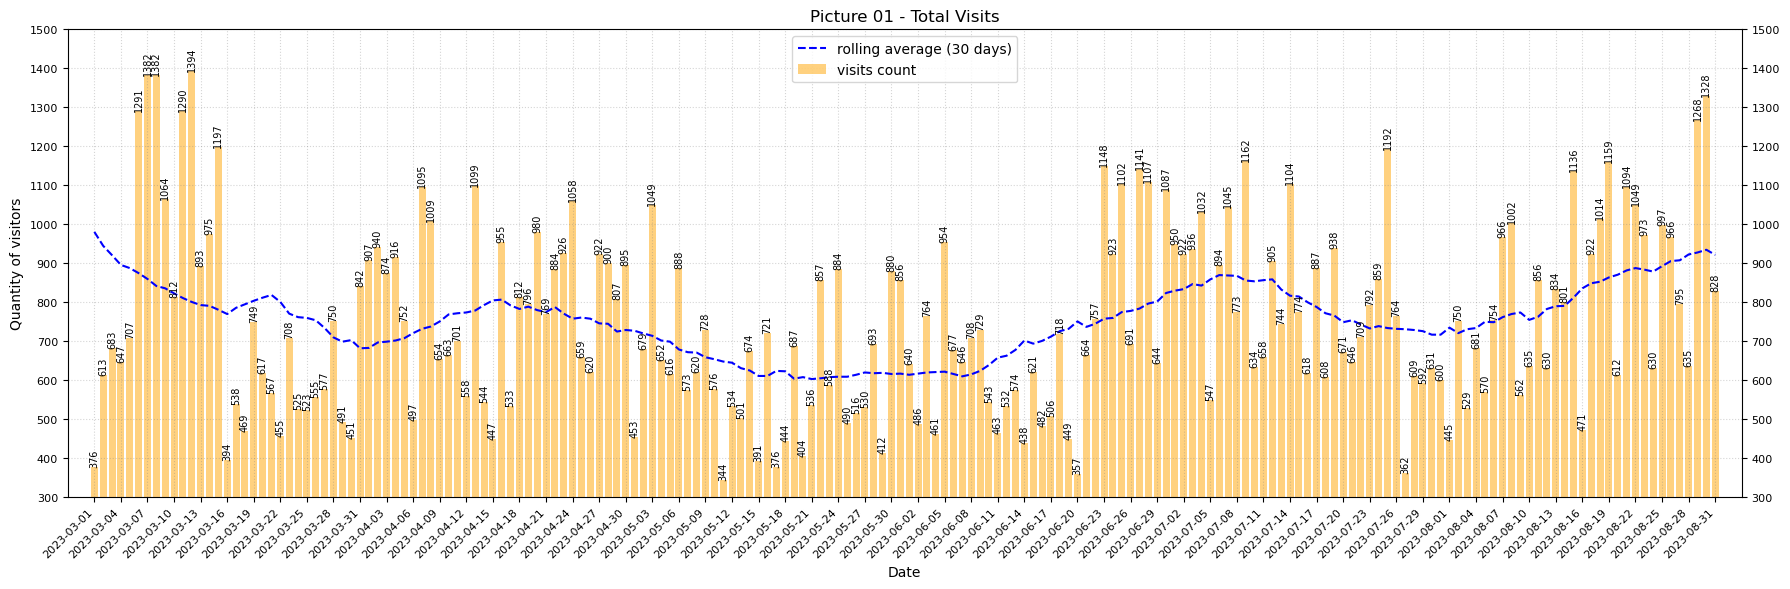

In [23]:
df = pd.read_json('ads.json')
df.date_group = pd.to_datetime(df.date_group).dt.date
#Setup figure and 'axe':
fig, pic = plt.subplots(figsize=(18, 6))
#Data set for the Picture:
pict_01_bars = df.groupby('date_group').agg(visits=('visits', 'sum')).reset_index()
#Adding rolling value:
pict_01_bars['rolling'] = pict_01_bars[['visits']].rolling(30, 1, center=True).mean().round(0)
#print(pict_01_bars)
#Picture creation (PYPLOT):
barchart = plt.bar(pict_01_bars['date_group'],
                   pict_01_bars['visits'],
                   color='orange',
                   alpha=0.5,
                   label='visits count')
pic.set(xlabel='Date',
        ylabel='Quantity of visitors',
        title='Picture 01 - Total Visits')
linechart = plt.plot(pict_01_bars['date_group'],
                     pict_01_bars['rolling'],
                     color='blue',
                     linestyle='dashed',
                     label='rolling average (30 days)')
#Settin up grids and ticks:
plt.grid(axis='both', ls=':', color='grey')
plt.yticks(np.arange(300, 1600, 100))
plt.xticks(pict_01_bars.date_group[::3])
#Rotate xlabels to 45 deg:
pic.tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
pic.tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
#Auto set of figure's margins
fig.tight_layout()
#Setting up limits for x an y axes:
pic.set_ylim(300, 1500)
xmargin = pd.Timedelta('3D') 
pic.set_xlim(pict_01_bars.date_group.min() - xmargin,
             pict_01_bars.date_group.max() + xmargin)
#X-ticks - set alignment of rotated labels:
plt.setp(pic.get_xticklabels(), ha='right')
#Bar labels show with 90deg rotation, color, size..:
pic.bar_label(pic.containers[0], rotation=90, fontsize=7, color='black')
plt.legend(loc='upper center')
#plt.show()
plt.savefig('./charts/Pic01.png')

<h3>5.2. Итоговые визиты. Распределение по платформам</h3>

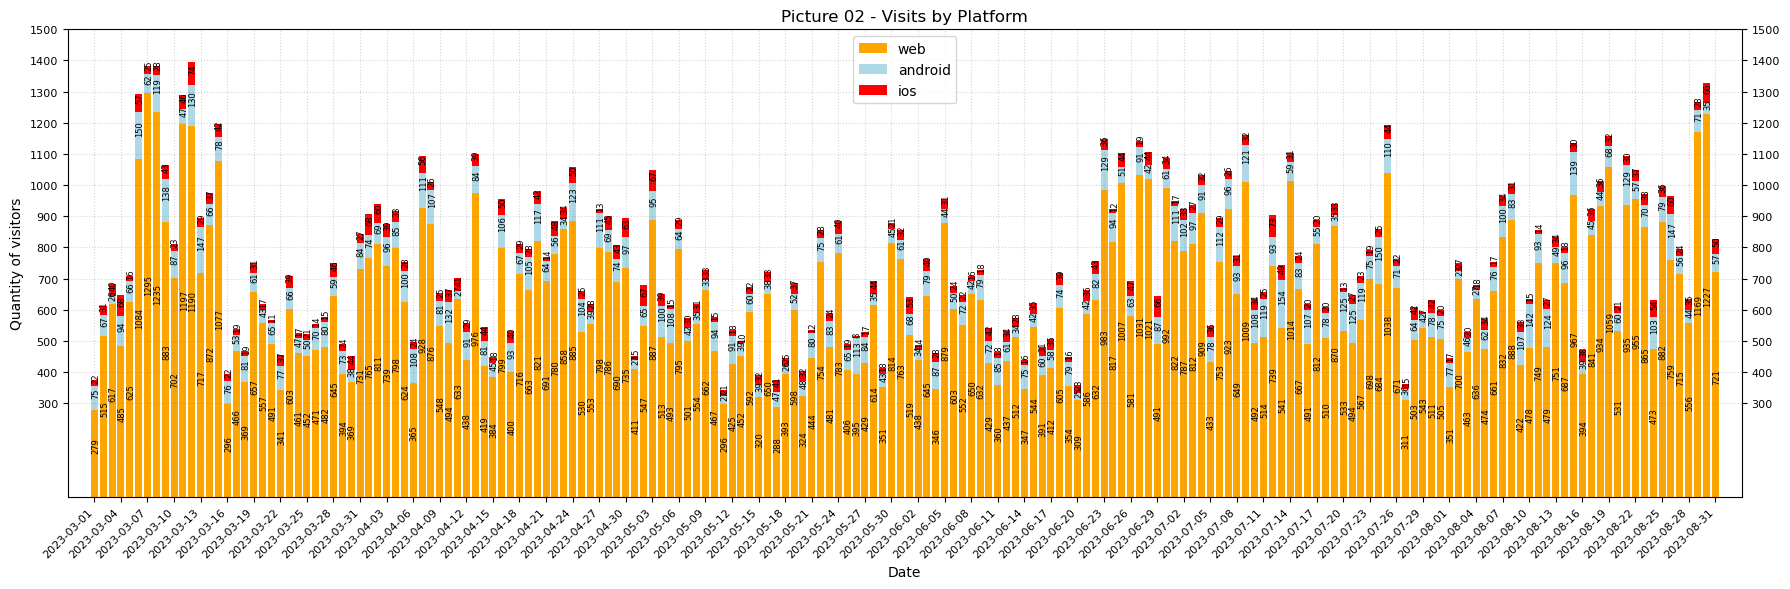

In [24]:
#Pivot table for representing platforms as separate columns:
bstck_pvt = pd.pivot_table(df,
                           values=['visits'],
                           columns=['platform'],
                           index=['date_group'],
                           aggfunc='sum',
                           dropna=False).reset_index()
bstck_pvt.columns = ['date_group', 'android', 'ios', 'web']
bstck_pvt['date_group'] = pd.to_datetime(bstck_pvt['date_group']).dt.date
#print(bstck_pvt)
#print(bstck_pvt.columns.to_list())
fig, ax = plt.subplots(figsize=(18, 6))
w = ax.bar(bstck_pvt.date_group,
           bstck_pvt.web,
           color='orange',
           label='web')
a = ax.bar(bstck_pvt.date_group,
           bstck_pvt.android,
           bottom=bstck_pvt.web,
           color='lightblue',
           label='android')
i = ax.bar(bstck_pvt.date_group,
           bstck_pvt.ios,
           bottom=bstck_pvt.web + bstck_pvt.android,
           color='red',
           label='ios')
#Setting up title and labels of axes:
ax.set(xlabel='Date',
       ylabel='Quantity of visitors',
       title='Picture 02 - Visits by Platform')
#Settin up grids and ticks:
plt.grid(axis='both', ls=':', color='grey')
plt.yticks(np.arange(300, 1600, 100))
plt.xticks(bstck_pvt.date_group[::3])
#Rotate xlabels to 45 deg:
ax.tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
ax.tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
#Auto set of figure's margins
fig.tight_layout()
#Setting up limits for x an y axes:
#ax.set_ylim(300, 1500)
xmargin = pd.Timedelta('3D') 
ax.set_xlim(bstck_pvt.date_group.min() - xmargin,
            bstck_pvt.date_group.max() + xmargin)
#X-ticks - set alignment of rotated labels:
plt.setp(ax.get_xticklabels(), ha='right')
#Bar labels show with 90deg rotation, color, size..
for r1, r2, r3 in zip(w, a, i):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width()/1.5,
             h1/2.,
             h1,
             ha='center',
             va='bottom',
             color='black',
             fontsize=6,
             #fontweight='bold',
             rotation=90)
    plt.text(r2.get_x() + r2.get_width()/1.5,
             h1 + h2/2.,
             h2,
             ha='center',
             va='bottom',
             color='black',
             fontsize=6,
             #fontweight='bold',
             rotation=90)
    plt.text(r3.get_x() + r3.get_width()/1.5,
             h1 + h2 + h3/2.,
             h3,
             ha='center',
             va='bottom',
             color='black',
             fontsize=6,
             #fontweight='bold',
             rotation=90)
plt.legend(loc='upper center')
#plt.show()
plt.savefig('./charts/Pic02.png')

<h3>5.3. Итоговые регистрации</h3>

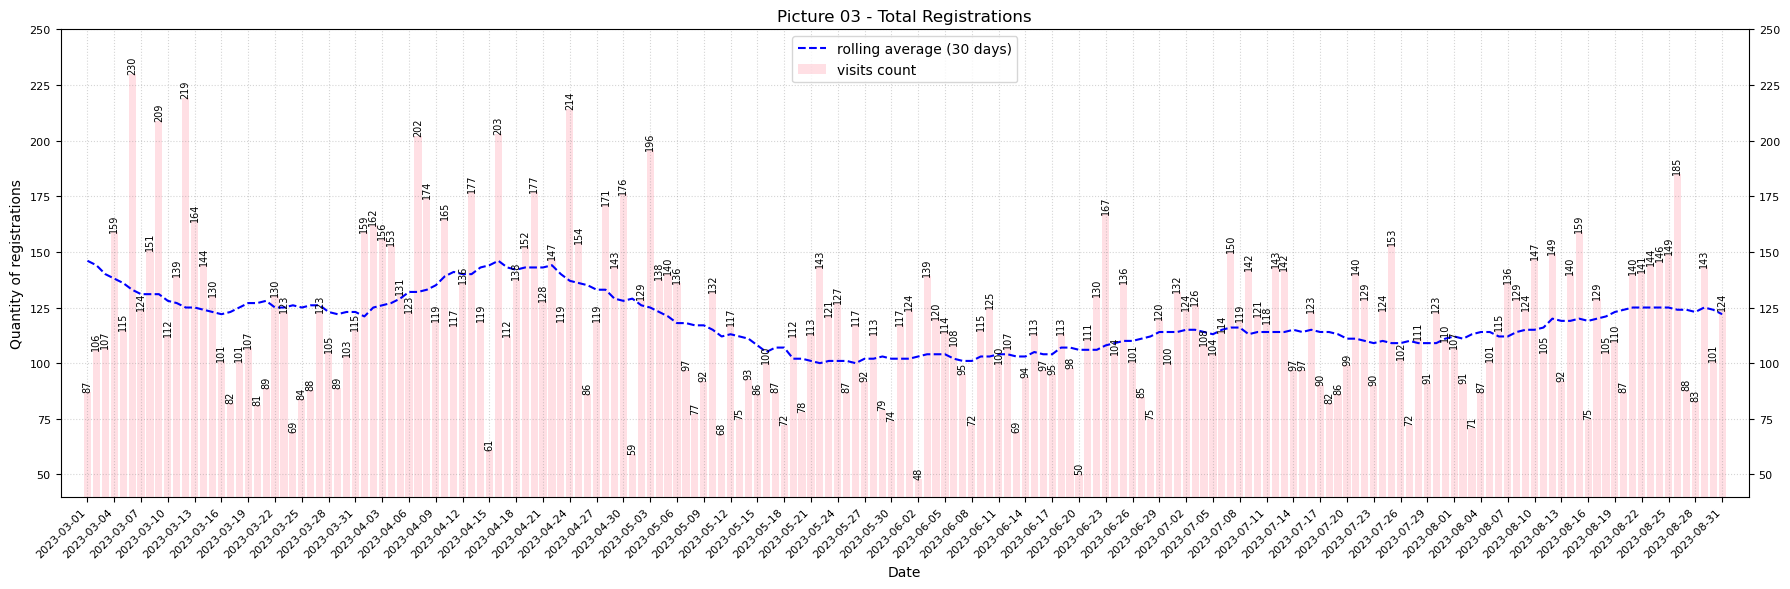

In [25]:
#Setup figure and 'axe':
fig, pic = plt.subplots(figsize=(18, 6))
#Data set for the Picture:
pict_01_bars = df.groupby('date_group').agg(registrations=('registrations', 'sum')).reset_index()
#Adding rolling value:
pict_01_bars['rolling'] = pict_01_bars[['registrations']].rolling(30, 1, center=True).mean().round(0)
#print(pict_01_bars)
#Picture creation (PYPLOT):
barchart = plt.bar(pict_01_bars['date_group'],
                   pict_01_bars['registrations'],
                   color='pink',
                   alpha=0.5,
                   label='visits count')
pic.set(xlabel='Date',
        ylabel='Quantity of registrations',
        title='Picture 03 - Total Registrations')
linechart = plt.plot(pict_01_bars['date_group'],
                     pict_01_bars['rolling'],
                     color='blue',
                     linestyle='dashed',
                     label='rolling average (30 days)')
#Settin up grids and ticks:
plt.grid(axis='both', ls=':', color='grey')
plt.xticks(pict_01_bars.date_group[::3])
#Rotate xlabels to 45 deg:
pic.tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
pic.tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
#Auto set of figure's margins
fig.tight_layout()
#Setting up limits for x an y axes:
pic.set_ylim(40, 250)
xmargin = pd.Timedelta('3D') 
pic.set_xlim(pict_01_bars.date_group.min() - xmargin,
             pict_01_bars.date_group.max() + xmargin)
#X-ticks - set alignment of rotated labels:
plt.setp(pic.get_xticklabels(), ha='right')
#Bar labels show with 90deg rotation, color, size..:
pic.bar_label(pic.containers[0], rotation=90, fontsize=7, color='black')
plt.legend(loc='upper center')
#plt.show()
plt.savefig('./charts/Pic03.png')

<h3>5.4. Итоговые регистрации. Распределение по платформам</h3>

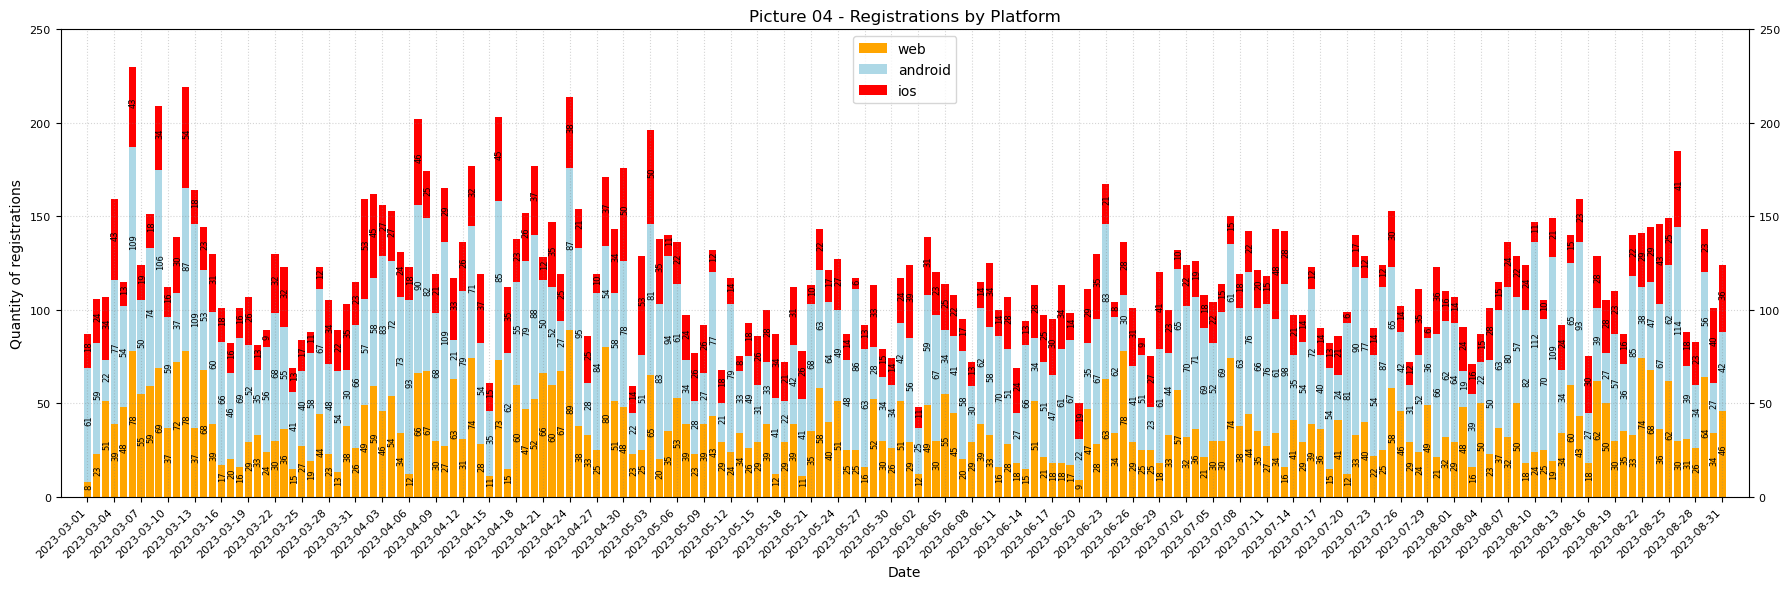

In [26]:
#Pivot table for representing platforms as separate columns:
regs_pvt = pd.pivot_table(df,
                          values=['registrations'],
                          columns=['platform'],
                          index=['date_group'],
                          aggfunc='sum',
                          dropna=False).reset_index()
regs_pvt.columns = ['date_group', 'android', 'ios', 'web']
regs_pvt['date_group'] = pd.to_datetime(regs_pvt['date_group']).dt.date
#print(regs_pvt)
#print(regs_pvt.columns.to_list())
fig, ax = plt.subplots(figsize=(18, 6))
w = ax.bar(regs_pvt.date_group,
           regs_pvt.web,
           color='orange',
           label='web')
a = ax.bar(regs_pvt.date_group,
           regs_pvt.android,
           bottom=regs_pvt.web,
           color='lightblue',
           label='android')
i = ax.bar(regs_pvt.date_group,
           regs_pvt.ios,
           bottom=regs_pvt.web + regs_pvt.android,
           color='red',
           label='ios')
#Setting up title and labels of axes:
ax.set(xlabel='Date',
       ylabel='Quantity of registrations',
       title='Picture 04 - Registrations by Platform')
#Settin up grids and ticks:
plt.grid(axis='both', ls=':', color='grey')
plt.yticks(np.arange(0, 300, 50))
plt.xticks(regs_pvt.date_group[::3])
#Rotate xlabels to 45 deg:
ax.tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
ax.tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
#Auto set of figure's margins
fig.tight_layout()
#Setting up limits for x an y axes:
#ax.set_ylim(300, 1500)
xmargin = pd.Timedelta('3D') 
ax.set_xlim(regs_pvt.date_group.min() - xmargin,
            regs_pvt.date_group.max() + xmargin)
#X-ticks - set alignment of rotated labels:
plt.setp(ax.get_xticklabels(), ha='right')
#Bar labels show with 90deg rotation, color, size..
for r1, r2, r3 in zip(w, a, i):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width()/1.5,
             h1/2.,
             h1,
             ha='center',
             va='bottom',
             color='black',
             fontsize=6,
             #fontweight='bold',
             rotation=90)
    plt.text(r2.get_x() + r2.get_width()/1.5,
             h1 + h2/2.,
             h2,
             ha='center',
             va='bottom',
             color='black',
             fontsize=6,
             #fontweight='bold',
             rotation=90)
    plt.text(r3.get_x() + r3.get_width()/1.5,
             h1 + h2 + h3/2.,
             h3,
             ha='center',
             va='bottom',
             color='black',
             fontsize=6,
             #fontweight='bold',
             rotation=90)
plt.legend(loc='upper center')
#plt.show()
plt.savefig('./charts/Pic04.png')

<h3>5.5. Итоговые конверсии</h3>

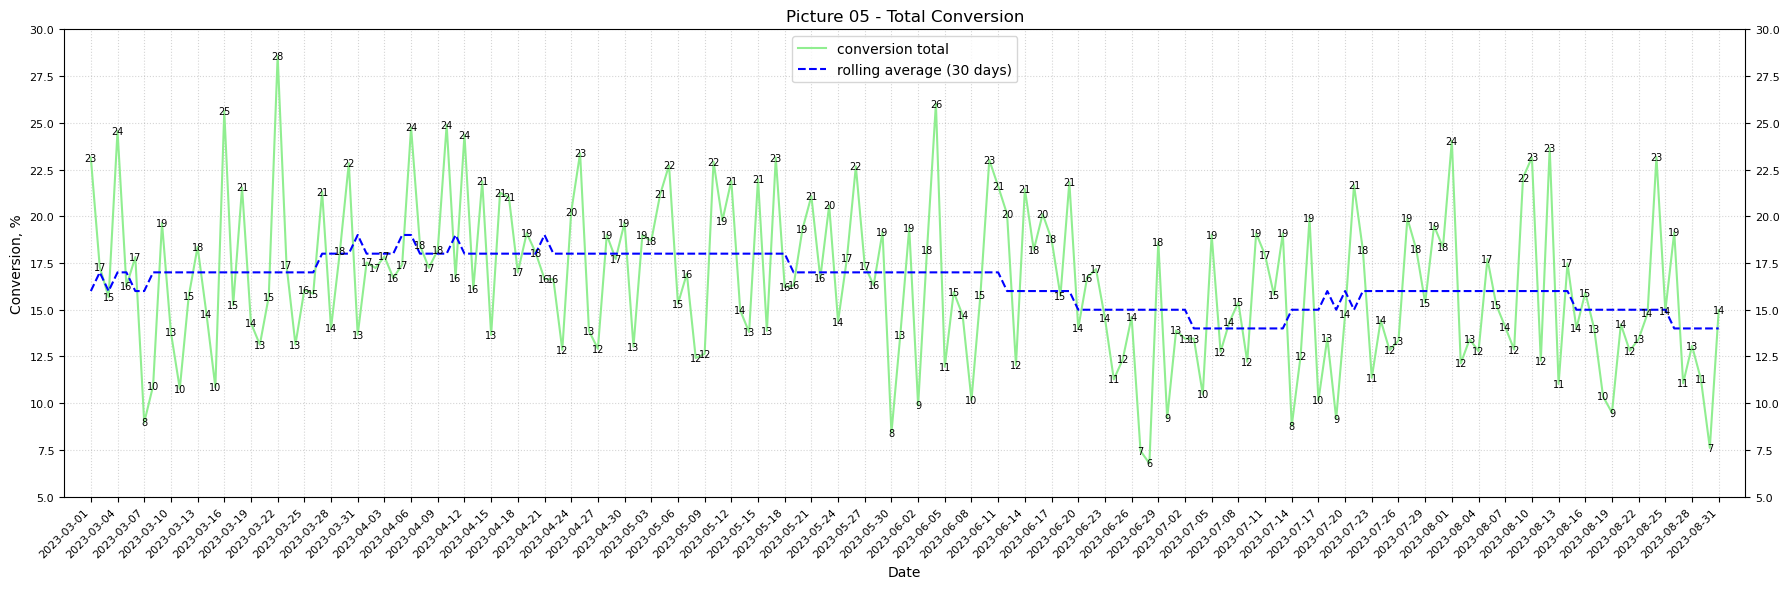

In [27]:
conv_ttl = pd.pivot_table(df,
                          values=['visits', 'registrations'],
                          index='date_group',
                          aggfunc='sum',
                          dropna=False).reset_index().round(2)
conv_ttl['conv_ttl'] = (100 * conv_ttl.registrations / conv_ttl.visits).round(2)
conv_ttl['roll'] = conv_ttl['conv_ttl'].rolling(30, 1, center=True).mean().round(0)
#print(conv_ttl)
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(conv_ttl['date_group'],
         conv_ttl['conv_ttl'],
         #marker='*',
         color='lightgreen',
         label='conversion total')
plt.plot(conv_ttl['date_group'],
         conv_ttl['roll'],
         color='blue',
         linestyle='dashed',
         label='rolling average (30 days)')
for x, y in zip(conv_ttl.date_group, conv_ttl.conv_ttl):
    plt.text(x, y, int(y), fontsize=7, fontweight='normal', rotation=0, ha='center', va='center')
ax.set(xlabel='Date',
       ylabel='Conversion, %',
       title='Picture 05 - Total Conversion')
#Settin up grids and ticks:
plt.grid(axis='both', ls=':', color='grey')
plt.yticks(np.arange(5, 35, 2.5))
plt.xticks(conv_ttl.date_group[::3])
#Rotate xlabels to 45 deg:
ax.tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
ax.tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
#Auto set of figure's margins
fig.tight_layout()
#Setting up limits for x an y axes:
ax.set_ylim(5, 30)
xmargin = pd.Timedelta('3D') 
ax.set_xlim(conv_ttl.date_group.min() - xmargin,
            conv_ttl.date_group.max() + xmargin)
#X-ticks - set alignment of rotated labels:
plt.setp(ax.get_xticklabels(), ha='right')
plt.legend(loc='upper center')
#plt.show()
plt.savefig('./charts/Pic05.png')

<h3>5.6. Конверсии по каждой платформе</h3>

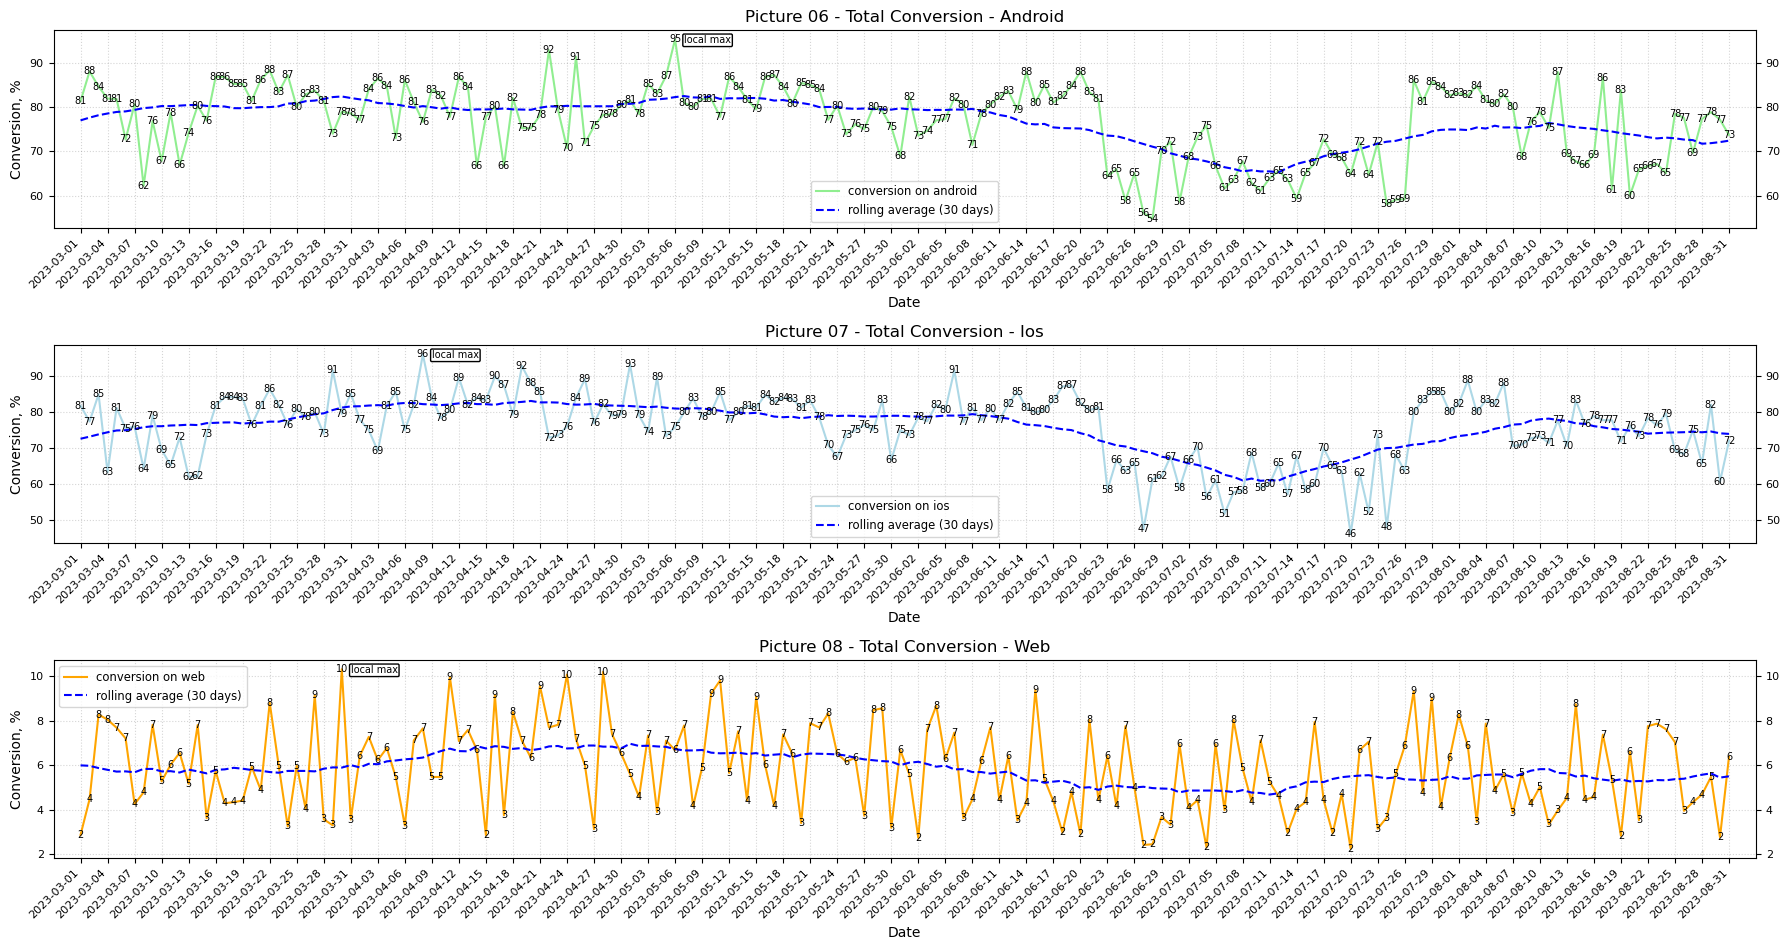

In [28]:
conv_pltf = pd.pivot_table(df,
                          values=['conversion'],
                          columns='platform',
                          index='date_group',
                          aggfunc='sum',
                          dropna=False).reset_index().round(2)
conv_pltf.columns = ['date_group', 'android', 'ios', 'web']
conv_pltf['roll_a'] = conv_pltf['android'].rolling(30, 1, center=True).mean().round(2)
conv_pltf['roll_i'] = conv_pltf['ios'].rolling(30, 1, center=True).mean().round(2)
conv_pltf['roll_w'] = conv_pltf['web'].rolling(30, 1, center=True).mean().round(2)
#print(conv_pltf)
fig, ax = plt.subplots(3, 1, figsize=(18, 9.6))
pltfrms = conv_pltf.columns.to_list()[1:4]
rolls = conv_pltf.columns.to_list()[4:]
colors = ['lightgreen', 'lightblue', 'orange']
for i, pltfrm in enumerate(pltfrms):
    ax[i].plot(conv_pltf['date_group'],
               conv_pltf[pltfrm],
               color=colors[i],
               label=f'conversion on {pltfrm}')
    ax[i].plot(conv_pltf['date_group'],
               conv_pltf[rolls[i]],
               color='blue',
               ls='--',
               label='rolling average (30 days)')
    for x, y in zip(conv_pltf['date_group'], conv_pltf[pltfrm]):
        ax[i].text(x, y, int(y),
                   fontsize=7,
                   fontweight='normal',
                   rotation=0,
                   ha='center',
                   va='center')
    ax[i].set(xlabel='Date',
              ylabel='Conversion, %',
              title=f'Picture 0{i+6} - Total Conversion - {pltfrm.title()}')
    #Settin up grids and ticks:
    ax[i].grid(axis='both', ls=':', color='grey')
    plt.sca(ax[i])
    plt.xticks(conv_pltf.date_group[::3])
    #Rotate xlabels to 45 deg:
    ax[i].tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
    ax[i].tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
    #Setting up limits for x an y axes:
    xmargin = pd.Timedelta('3D') 
    ax[i].set_xlim(conv_pltf.date_group.min() - xmargin,
                   conv_pltf.date_group.max() + xmargin)
    #X-ticks - set alignment of rotated labels:
    plt.setp(ax[i].get_xticklabels(), ha='right')
    ymax = conv_pltf[pltfrm].max()
    xmax = conv_pltf[conv_pltf[pltfrm] == ymax]['date_group']
    #print(ymax)
    #print(xmax)
    ax[i].annotate('local max',
                   xy=(xmax, ymax),
                   xytext=(xmax+xmargin/2, ymax),
                   fontsize=7,
                   ha='left',
                   va='center_baseline',
                   bbox=dict(facecolor='white',
                             edgecolor='black',
                             boxstyle='round,pad=0.13'))
    leg_pos = ['lower center', 'lower center', 'upper left']
    ax[i].legend(fontsize='small', loc=leg_pos[i])

fig.tight_layout()
#plt.show()
plt.savefig('./charts/Pic06-07-08.png')

<h3>5.7. Стоимость рекламных кампаний</h3>

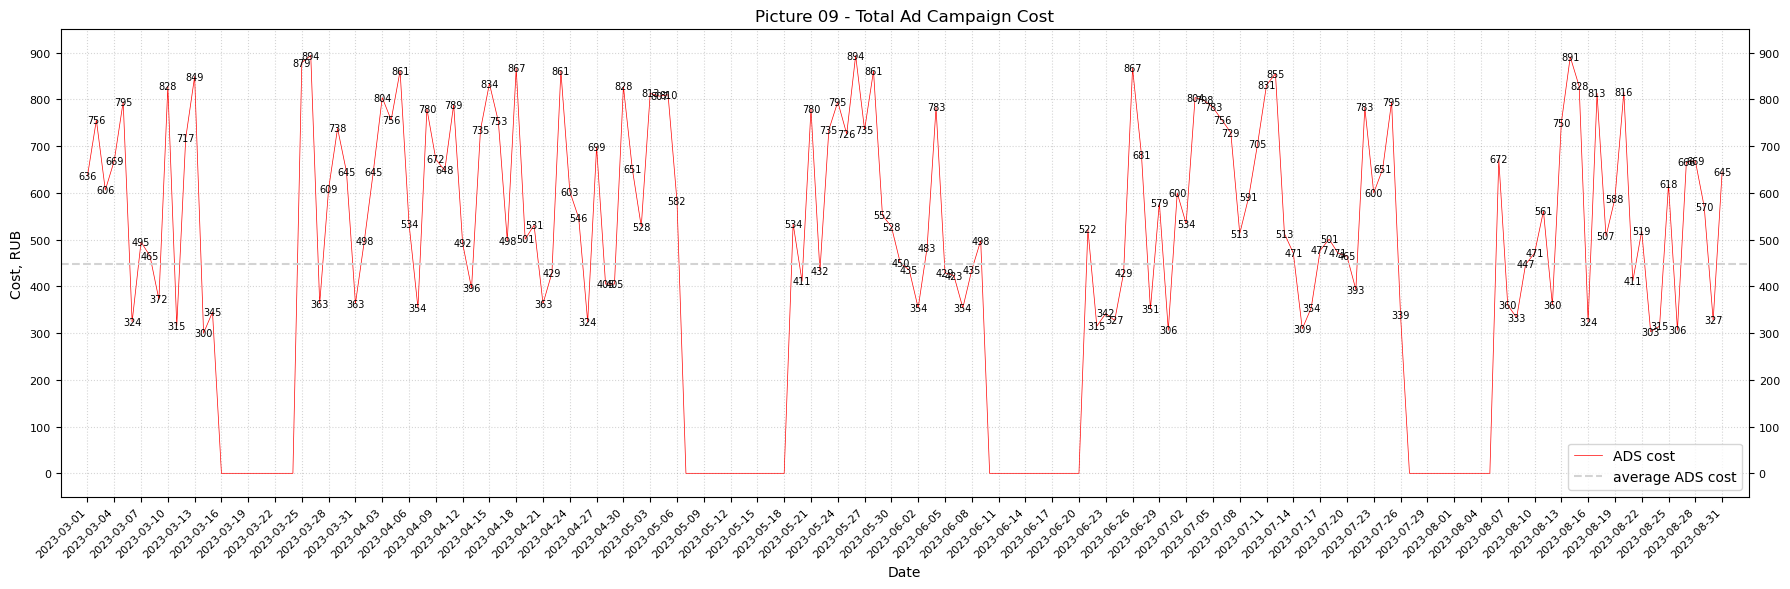

In [29]:
cost_pvt = pd.pivot_table(df,
                          values='cost',
                          index='date_group',
                          aggfunc='sum',
                          dropna=False).reset_index()
cost_pvt.cost = cost_pvt.cost.astype(int)
source_pvt = df[['date_group', 'utm_source']].groupby(df['date_group']).head(1).set_index('date_group')
cost_source = cost_pvt.set_index('date_group').join(source_pvt['utm_source'], on='date_group')
fig, ax = plt.subplots(figsize=(18, 6))
total = plt.plot(#cost_source['date_group'], <-- when 'date_group' is index
                 cost_source['cost'],
                 color='red',
                 linewidth=0.5,
                 label='ADS cost')
for x, y in zip(cost_pvt.date_group, cost_pvt.cost):
    plt.text(x,
             y,
             int(y) if y > 0 else '',
             fontsize=7,
             fontweight='normal',
             rotation=0,
             ha='center',
             va='center')
average = plt.axhline(cost_source['cost'].agg('mean'),
                      color='lightgrey',
                      ls='--',
                      label='average ADS cost')
ax.set(xlabel='Date',
       ylabel='Cost, RUB',
       title='Picture 09 - Total Ad Campaign Cost')
#Settin up grids and ticks:
plt.grid(axis='both', ls=':', color='grey')
plt.yticks(np.arange(0, 950, 100))
plt.xticks(cost_pvt.date_group[::3])
#Rotate xlabels to 45 deg:
ax.tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
ax.tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
#Setting up limits for x an y axes:
ax.set_ylim(-50, 950)
xmargin = pd.Timedelta('3D') 
ax.set_xlim(cost_pvt.date_group.min() - xmargin,
            cost_pvt.date_group.max() + xmargin)
#X-ticks - set alignment of rotated labels:
plt.setp(ax.get_xticklabels(), ha='right')
#Auto set of figure's margins
fig.tight_layout()
plt.legend()
#plt.show()
plt.savefig('./charts/Pic09.png')

<h3>5.8. Визиты и регистрации с выделением рекламных кампаний</h3>

In [30]:
import matplotlib.dates as dt
from matplotlib.colors import ListedColormap

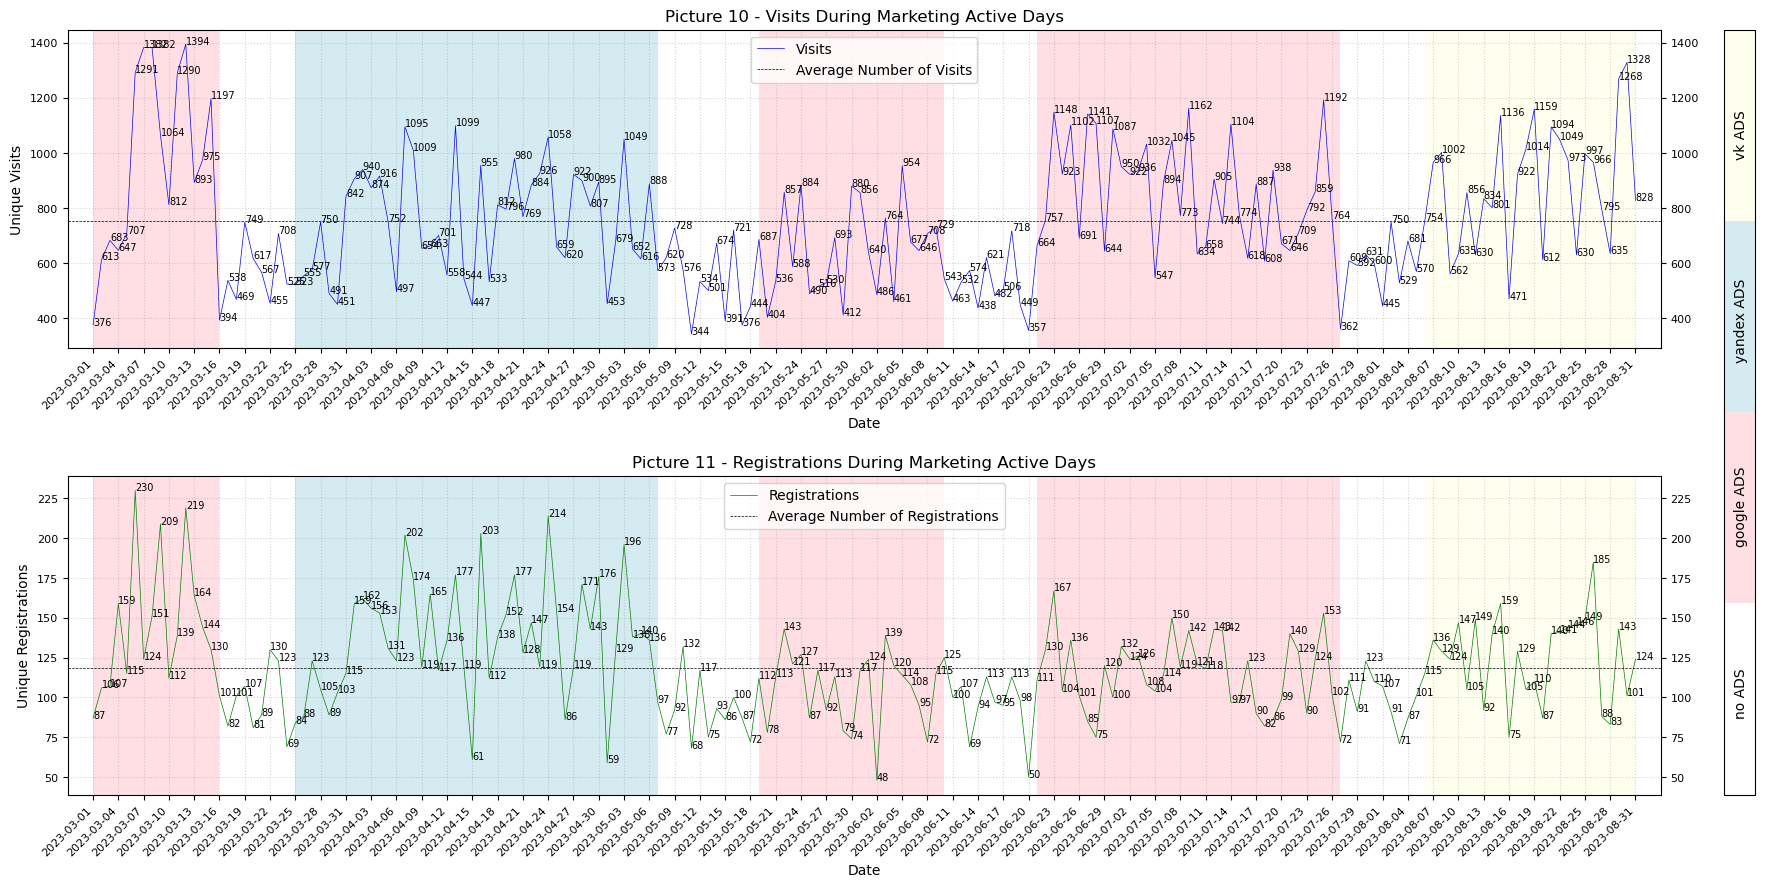

In [31]:
v_r_pvt = pd.pivot_table(df,
                         values=['visits', 'registrations', 'utm_source'],
                         index='date_group',
                         aggfunc={'visits': 'sum',
                                  'registrations': 'sum',
                                  'utm_source': 'first'},
                         dropna=False)#.reset_index()
v_r_pvt = v_r_pvt[['visits', 'registrations', 'utm_source']]
#print(v_r_pvt)

def source_to_num(x):
    if x == None:
        return 0
    elif x == 'google':
        return 1
    elif x == 'yandex':
        return 2
    elif x == 'vk':
        return 3
    else:
        return 4

v_r_pvt['color'] = v_r_pvt['utm_source'].apply(lambda x: source_to_num(x))
#print(v_r_pvt)

fig, ax = plt.subplots(2, 1, figsize=(18, 9))#, sharex=True)
#Visits:
vsts = ax[0].plot(v_r_pvt['visits'],
                  color='blue',
                  linewidth=0.5,
                  label='Visits')
#Text labels:
for x, y in zip(v_r_pvt.index, v_r_pvt.visits):
    ax[0].text(x, y, int(y),
               fontsize=7)
#Color background:
bckg = ax[0].pcolormesh(v_r_pvt.index,
                        ax[0].get_ylim(),
                        v_r_pvt['color'].values[:-1][np.newaxis],
                        cmap=ListedColormap(['white', 'pink', 'lightblue', 'lightyellow']),
                        alpha=0.5)
#Average line:
avg = ax[0].axhline(v_r_pvt['visits'].agg('mean'),
                    color='black',
                    linewidth=0.5,
                    ls='--',
                    label='Average Number of Visits')
#Registrations:
regs = ax[1].plot(v_r_pvt['registrations'],
                  color='green',
                  linewidth=0.5,                       
                  label='Registrations')
#Text labels:
for x, y in zip(v_r_pvt.index, v_r_pvt.registrations):
    ax[1].text(x, y, int(y),             
               fontsize=7)
#Color background:
bckg = ax[1].pcolormesh(v_r_pvt.index,
                        ax[1].get_ylim(),                       
                        v_r_pvt['color'].values[:-1][np.newaxis],                       
                        cmap=ListedColormap(['white', 'pink', 'lightblue', 'lightyellow']),
                        alpha=0.5)
#Average line:
avg = ax[1].axhline(v_r_pvt['registrations'].agg('mean'),
                    color='black',
                    linewidth=0.5,
                    ls='--',
                    label='Average Number of Registrations')

#Appearance:
ax[0].set(xlabel='Date',
          ylabel='Unique Visits',
          title='Picture 10 - Visits During Marketing Active Days')
ax[1].set(xlabel='Date',
          ylabel='Unique Registrations',
          title='Picture 11 - Registrations During Marketing Active Days')
#Setting up grids and ticks:
for i in range(2):
    ax[i].grid(axis='both', ls=':', color='grey')
    ax[i].set_xticks(v_r_pvt.index[::3])
    #Rotate xlabels to 45 deg:
    ax[i].tick_params(axis='x', labelsize=8, labelrotation=45, grid_alpha=0.33)
    ax[i].tick_params(axis='y', labelsize=8, labelright=True, right=True, grid_alpha=0.33)
    #Setting up limits for x an y axes:
    xmargin = pd.Timedelta('3D') 
    ax[i].set_xlim(v_r_pvt.index.min() - xmargin,
                   v_r_pvt.index.max() + xmargin)
    #X-ticks - set alignment of rotated labels:
    plt.setp(ax[i].get_xticklabels(), ha='right')
    ax[i].legend(loc='upper center')
#Setting up colorbar:
cbax = fig.add_axes((0.97, 0.1, 0.0175, 0.85))
cbar = plt.colorbar(bckg, cax=cbax)
cbar.ax.get_yaxis().set_ticks([])
for j, label in enumerate(['no ADS', 'google ADS', 'yandex ADS', 'vk ADS']):
    cbar.ax.text(0.55, (1.825 * j + 1) / 2.5,
                 label,
                 ha='center',
                 va='center',
                 rotation=90,
                 fontweight='medium')

plt.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.935, hspace=0.4)
#plt.show()
plt.savefig('./charts/Pic10-11.png')